In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date
from math import ceil

from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix

In [267]:
data = pd.read_csv('data/train.csv',
                       encoding = "ISO-8859-1",
                       sep=';',
                       skiprows=1,
                       names=['Дата','Количество поступивших вызовов',
                              'Количество принятых вызовов','Количество потерянных вызовов',
                              'Ср. скорость ответа оператора (сек.)','Ср. время разговора (сек.)',
                              'Ср. число операторов','Макс. число операторов'])
print(data.shape)

target_data = pd.read_csv('data/submission_sample.csv',
                       encoding = "ISO-8859-1",
                       sep=';',
                       skiprows=1,
                       names=['Дата','Количество поступивших вызовов'])
print(target_data.shape)

data['Дата'] = pd.to_datetime(data['Дата'], format='%d.%m.%Y')
target_data['Дата'] = pd.to_datetime(target_data['Дата'], format='%d.%m.%Y')

print(data['Дата'].dtype)
print(target_data['Дата'].dtype)

(549, 8)
(61, 2)
datetime64[ns]
datetime64[ns]


## Preprocessing

In [268]:
df = pd.DataFrame()
df[['date', 'target']] = data[['Дата','Количество поступивших вызовов']]

target_df = pd.DataFrame()
target_df[['date', 'target']] = target_data[['Дата','Количество поступивших вызовов']]

In [269]:
def get_parsed_data(time):
    parsed = time
    return parsed.year, parsed.month, parsed.day, parsed.weekday() #, parsed.minute, parsed.second

df['year'], df['month'], df['day'], df['weekday'] = zip(*df.date.apply(get_parsed_data))
target_df['year'], target_df['month'], target_df['day'], target_df['weekday'] = \
                        zip(*target_df.date.apply(get_parsed_data))

In [270]:
def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

df['week_of_month'] = df.date.apply(week_of_month)
target_df['week_of_month'] = target_df.date.apply(week_of_month)

In [271]:
def is_in_13_19(dt):
    day = dt.day
    if day in [13,14,15,16,17,18,19]:
        return 1
    return 0

def is_in_16_18(dt):
    day = dt.day
    if day in [14,15,16,17]:
        return 1
    return 0

df['13_19'] = df.date.apply(is_in_13_19)
df['16_18'] = df.date.apply(is_in_16_18)

target_df['13_19'] = target_df.date.apply(is_in_13_19)
target_df['16_18'] = target_df.date.apply(is_in_16_18)

In [272]:
temp_df = df.groupby(['year','month', 'week_of_month']).agg({'week_of_month': 'count'})
vals = temp_df.values
temp_df['days_in_week'] = vals
del temp_df['week_of_month']
df = df.join(temp_df, how='left', on=['year','month', 'week_of_month'])

temp_df = target_df.groupby(['year','month', 'week_of_month']).agg({'week_of_month': 'count'})
vals = temp_df.values
temp_df['days_in_week'] = vals
del temp_df['week_of_month']
target_df = target_df.join(temp_df, how='left', on=['year','month', 'week_of_month'])


In [273]:
def short_1st_week(dframe, y, m):
    first_week = dframe[(dframe.year == y) &
                   (dframe.month == m) &
                   (dframe['week_of_month'] == 1)]
    if first_week.days_in_week.head(1).values < 5:
        return 1
    return 0

short_1st_week_arr = np.zeros(df.shape[0])
for row in range(df.shape[0]):
    y = df.iloc[row].year
    m = df.iloc[row].month    
    short_1st_week_arr[row] = short_1st_week(df, y, m)       
df['short_1st_week'] = short_1st_week_arr


short_1st_week_arr = np.zeros(target_df.shape[0])
for row in range(target_df.shape[0]):
    y = target_df.iloc[row].year
    m = target_df.iloc[row].month    
    short_1st_week_arr[row] = short_1st_week(target_df, y, m)       
target_df['short_1st_week'] = short_1st_week_arr

In [274]:
df.week_of_month = df.week_of_month - df.short_1st_week
target_df.week_of_month = target_df.week_of_month - target_df.short_1st_week

In [275]:
df['weekday_week_of_month'] =  df['weekday'].astype(str) + '_' + df['week_of_month'].astype(str)
target_df['weekday_week_of_month'] = \
            target_df['weekday'].astype(str) + '_' + target_df['week_of_month'].astype(str)

In [276]:
# cut outliers in train set

outl = np.mean(df['target']) + 3*np.std(df['target'])
df['target'][df['target'] > outl] = outl

/home/innodata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [277]:
features = ['month',
            'day',
            'weekday',
            'week_of_month',
            '13_19',
            'weekday_week_of_month',
            '16_18'
           ]

target = 'target'

In [278]:
date_to_cut = date(2018,9,1)
big_df = df.append(target_df).reset_index()
print(df.shape, target_df.shape)

(549, 12) (61, 12)


In [279]:
# add year-back feature

big_df['target_shift_year'] = big_df[target].shift(364)

In [280]:
import random
null_indices = big_df['target_shift_year'].isnull()
std = int(np.std(df[target]))
min_bound = np.min(df[target])
max_bound = np.max(df[target])

random.seed(42)
stands = [ random.randrange(-std, std)/4 for i in range(len(big_df[null_indices]))]
aprox_shift = big_df[null_indices][target] + stands
aprox_shift[aprox_shift < min_bound] = min_bound
aprox_shift[aprox_shift > max_bound] = max_bound

In [281]:
aprox_shift = aprox_shift.append(big_df[null_indices==False]['target_shift_year'])
big_df['target_shift_year']  = aprox_shift

In [282]:
# cut outliers

outl = np.mean(big_df['target_shift_year']) + 3*np.std(big_df['target_shift_year'])
big_df['target_shift_year'][big_df['target_shift_year'] > outl] = outl

/home/innodata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


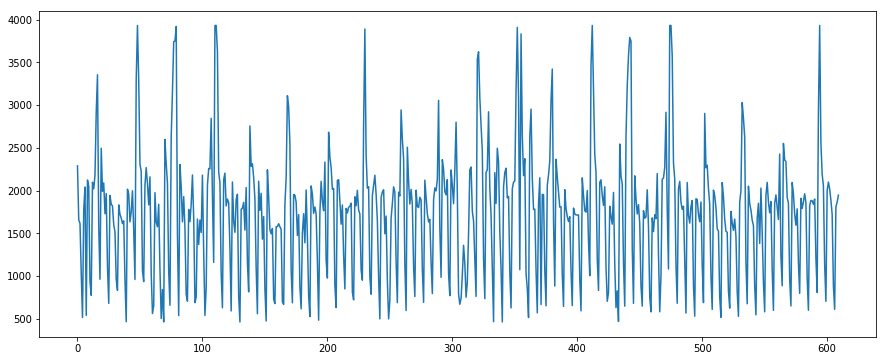

In [283]:
plt.figure(figsize=(15,6))
plt.plot(big_df['target_shift_year'])
plt.show()

In [284]:
#     1, 2, 3, 4, 5 и 8 января — Новогодние каникулы;
#     7 января — Рождество Христово;
#     23 февраля — День защитника Отечества;
#     8 марта — Международный женский день;
#     1 мая — Праздник Весны и Труда;
#     9 мая — День Победы;
#     12 июня — День России;
#     4 ноября — День народного единства.

def is_holiday(month_day):
    
    holidays = [(1,1), (1,2), (1,3), (1,4), (1,5), (1,6), (1,7), (1,8),
               (2, 23), (3, 8), (5, 1), (5, 9), (6, 12), (11, 4)]
    
    if month_day in holidays:
        return 1
    return 0

s_month_day = pd.Series(list(zip(big_df['month'], big_df['day']))) #list(zip(df.lat, df.long))
big_df['is_holiday'] = s_month_day.apply(is_holiday)

In [285]:
# date_to_cut

df = big_df[big_df.date < date_to_cut]
target_df = big_df[big_df.date >= date_to_cut]

print(df.shape, target_df.shape)

(549, 15) (61, 15)


/home/innodata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/innodata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Comparing Series of datetimes with 'datetime.date'.  Currently, the
'datetime.date' is coerced to a datetime. In the future pandas will
not coerce, and a TypeError will be raised. To retain the current
behavior, convert the 'datetime.date' to a datetime with
'pd.Timestamp'.
  after removing the cwd from sys.path.


In [309]:
features = ['month',
            'day',
            'weekday',
            'week_of_month',
#             '13_19',
            'weekday_week_of_month',
#             '16_18',
            'target_shift_year',
            'is_holiday'
           ]

target = 'target'

## Model

In [310]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

In [329]:
cat_parameters = {
#                 'n_estimators':[50, 100, 500, 1000],
#                   'max_depth':[10, 5, 2],
#                   'learning_rate':[.5, 1],
#                   'loss_function':['RMSE']
}

cat_model = CatBoostRegressor(random_state=42,
                             verbose=-1)

ct_gscv = GridSearchCV(cat_model, cat_parameters, cv=5, scoring='neg_mean_absolute_error')
ct_gscv.fit(df[features][:(df.shape[0]-30)], df[target][:(df.shape[0]-30)])

/home/innodata/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=<catboost.core.CatBoostRegressor object at 0x7fd4ba89af60>,
       fit_params=None, iid='warn', n_jobs=None, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [330]:
print(- ct_gscv.best_score_)
print(ct_gscv.cv_results_['mean_train_score'])
print(ct_gscv.cv_results_['mean_test_score'])
print(ct_gscv.best_params_)
print()
print('Feature importances')
pd.DataFrame(ct_gscv.best_estimator_.feature_importances_,
             ct_gscv.best_estimator_.feature_names_).sort_values(0, ascending=False).head(10)

195.7005439338256
[-132.35398664]
[-195.70054393]
{}

Feature importances


/home/innodata/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,0
target_shift_year,46.364653
weekday_week_of_month,15.662932
weekday,12.319725
is_holiday,9.323995
day,9.134433
week_of_month,3.648471
month,3.545790


In [331]:

pred = ct_gscv.predict(df[features][(df.shape[0]-30):])
real =  df[target][(df.shape[0]-30):].values


mean_pred = [np.mean(pred) for i in range(len(pred))]
mean_real = [np.mean(real) for i in range(len(real))]

230.71753269023318


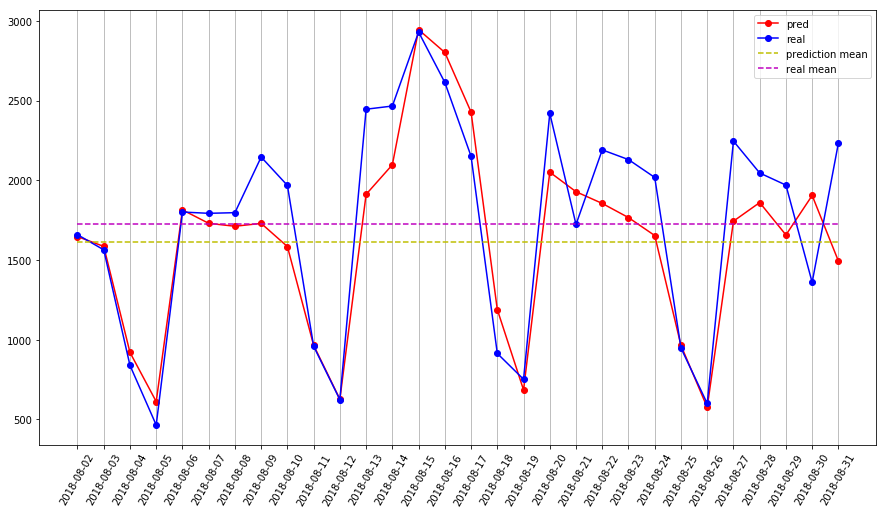

In [333]:

print(mean_absolute_error(real, pred))

plt.figure(figsize=(15,8))
plt.plot(pred, 'r-o', label='pred')
plt.plot(real, 'b-o', label='real')

plt.plot(mean_pred, 'y--', label='prediction mean')
plt.plot(mean_real, 'm--', label='real mean')

plt.xticks(np.arange(30), [str(d)[:10] for d in df.date[(df.shape[0]-30):].values], rotation=60)
plt.gca().xaxis.grid(True)
plt.legend()
plt.show()

## Prediction

In [316]:
target_df.head()

,index,date,target,year,month,day,weekday,week_of_month,13_19,16_18,days_in_week,short_1st_week,weekday_week_of_month,target_shift_year,is_holiday
549,0,2018-09-01,0.0,2018,9,1,5,0.0,0,0,2,1.0,5_0.0,925.0,0
550,1,2018-09-02,0.0,2018,9,2,6,0.0,0,0,2,1.0,6_0.0,584.0,0
551,2,2018-09-03,0.0,2018,9,3,0,1.0,0,0,7,1.0,0_1.0,1945.0,0
552,3,2018-09-04,0.0,2018,9,4,1,1.0,0,0,7,1.0,1_1.0,2098.0,0
553,4,2018-09-05,0.0,2018,9,5,2,1.0,0,0,7,1.0,2_1.0,1871.0,0


In [335]:
cat_parameters = {}

cat_model = CatBoostRegressor(random_state=42,
                             verbose=-1)

ct_gscv = GridSearchCV(cat_model, cat_parameters, cv=5, scoring='neg_mean_absolute_error')
ct_gscv.fit(df[features], df[target])

/home/innodata/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=<catboost.core.CatBoostRegressor object at 0x7fd4c08aa160>,
       fit_params=None, iid='warn', n_jobs=None, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [336]:
print(- ct_gscv.best_score_)
print(ct_gscv.cv_results_['mean_train_score'])
print(ct_gscv.cv_results_['mean_test_score'])
print(ct_gscv.best_params_)
print()
print('Feature importances')
pd.DataFrame(ct_gscv.best_estimator_.feature_importances_,
             ct_gscv.best_estimator_.feature_names_).sort_values(0, ascending=False).head(10)

195.1799473417663
[-131.84571642]
[-195.17994734]
{}

Feature importances


/home/innodata/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


,0
target_shift_year,50.647387
weekday_week_of_month,14.643536
is_holiday,10.882436
weekday,10.754922
day,5.393498
week_of_month,4.234631
month,3.443589


In [338]:
target_prediction = ct_gscv.predict(target_df[features])
target_prediction

array([1038.46807439,  627.78046284, 1920.00888756, 1936.52185359,
       1836.04898349, 1797.85902392, 1793.86813473, 1052.10250795,
        574.6578902 , 1933.17802486, 1976.88552591, 1890.51815592,
       1815.43660198, 2334.38765465, 1206.83565086,  825.66413268,
       2460.48194416, 2341.32982345, 2326.43521188, 1950.99669082,
       1882.46135887,  994.67381371,  649.76133976, 2046.27909731,
       1948.73751882, 1814.67798615, 1741.32450108, 1779.55065036,
       1109.019132  ,  661.78686121, 2029.74186793, 1811.76463171,
       1807.4476345 , 1855.77620629, 1803.84988298, 1012.75328655,
        591.45692773, 1917.40762029, 1925.5971037 , 1919.80792552,
       1902.4054513 , 1932.0113982 , 1222.63890297,  741.49335716,
       2792.82793997, 3370.54433881, 2508.93165108, 2195.17655958,
       2051.99122393, 1126.88227412,  703.86894876, 2046.61625682,
       2060.33080015, 1995.71924263, 1893.88330532, 1770.78792499,
        980.89798357,  591.87548034, 1915.44072793, 1899.97557

In [352]:
target_df[target] = target_prediction
final_target_df = pd.DataFrame()
final_target_df[['Дата','Количество поступивших вызовов']] = target_df[['date','target']]
# final_target_df = final_target_df.reset_index()
final_target_df.to_csv('out/Tukhvatov_Nikitin.csv', index=False)

/home/innodata/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


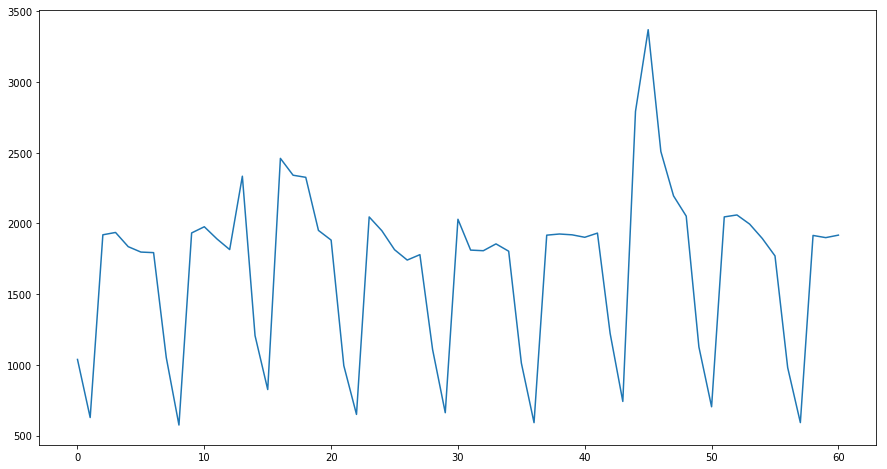

In [341]:
plt.figure(figsize=(15,8))

plt.plot(target_prediction)
plt.show()